# Step 1: Data Loading and Initial Inspection

In [3]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


life_expectancy_data = pd.read_csv('Life Expectancy Data.csv')

print(life_expectancy_data.head())
print(life_expectancy_data.info())

       Country  Year      Status  Adult Mortality  infant deaths  Alcohol  \
0  Afghanistan  2015  Developing            263.0             62     0.01   
1  Afghanistan  2014  Developing            271.0             64     0.01   
2  Afghanistan  2013  Developing            268.0             66     0.01   
3  Afghanistan  2012  Developing            272.0             69     0.01   
4  Afghanistan  2011  Developing            275.0             71     0.01   

   percentage expenditure  Hepatitis B  Measles    BMI   ...  \
0               71.279624         65.0      1154   19.1  ...   
1               73.523582         62.0       492   18.6  ...   
2               73.219243         64.0       430   18.1  ...   
3               78.184215         67.0      2787   17.6  ...   
4                7.097109         68.0      3013   17.2  ...   

   Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0               8.16         65.0        0.1  584.259210  33736494.0   
1       

# Step 2: Pre-processing for Regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Handling missing values by filling them with the mean of the column
life_expectancy_data.fillna(life_expectancy_data.mean(), inplace=True)

# Encoding categorical variables using one-hot encoding
life_expectancy_data = pd.get_dummies(life_expectancy_data, drop_first=True)

X = life_expectancy_data.drop(columns=['Life expectancy '])
y = life_expectancy_data['Life expectancy ']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Model Implementation

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg_pred = lin_reg.predict(X_test)

# Random Forest
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

# Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

# XGBoost
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

# LightGBM
lgb_reg = lgb.LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)
lgb_pred = lgb_reg.predict(X_test)

# CatBoost
cb_reg = cb.CatBoostRegressor(verbose=0, random_state=42)
cb_reg.fit(X_train, y_train)
cb_pred = cb_reg.predict(X_test)

# Stacking Regressor
estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('svr', SVR()),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('lgb', lgb.LGBMRegressor(random_state=42)),
    ('cb', cb.CatBoostRegressor(verbose=0, random_state=42))
]
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_reg.fit(X_train, y_train)
stacking_pred = stacking_reg.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 2350, number of used features: 20
[LightGBM] [Info] Start training from score 69.276978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 2350, number of used features: 20
[LightGBM] [Info] Start training from score 69.276978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3281
[LightGBM] [Info] Number of data points in the train set

# Step 4: Optimization with Optuna

In [11]:
import optuna

def optimize_rf_reg(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf_reg.fit(X_train, y_train)
    preds = rf_reg.predict(X_test)
    return mean_squared_error(y_test, preds)

rf_reg_study = optuna.create_study(direction='minimize')
rf_reg_study.optimize(optimize_rf_reg, n_trials=20)
best_rf_reg_params = rf_reg_study.best_params
print(f"Best parameters for Random Forest: {best_rf_reg_params}")

[I 2024-05-22 05:57:52,334] A new study created in memory with name: no-name-e1239361-f903-4732-9578-b3487186a7f8
[I 2024-05-22 05:59:05,404] Trial 0 finished with value: 2.6014655778722346 and parameters: {'n_estimators': 954, 'max_depth': 30}. Best is trial 0 with value: 2.6014655778722346.
[I 2024-05-22 05:59:54,464] Trial 1 finished with value: 2.588581231793036 and parameters: {'n_estimators': 515, 'max_depth': 32}. Best is trial 1 with value: 2.588581231793036.
[I 2024-05-22 06:00:59,490] Trial 2 finished with value: 2.601491519173984 and parameters: {'n_estimators': 878, 'max_depth': 25}. Best is trial 1 with value: 2.588581231793036.
[I 2024-05-22 06:01:11,628] Trial 3 finished with value: 2.814335482191458 and parameters: {'n_estimators': 225, 'max_depth': 12}. Best is trial 1 with value: 2.588581231793036.
[I 2024-05-22 06:01:42,760] Trial 4 finished with value: 2.5898081281092606 and parameters: {'n_estimators': 451, 'max_depth': 20}. Best is trial 1 with value: 2.5885812317

Best parameters for Random Forest: {'n_estimators': 484, 'max_depth': 20}


In [17]:
import optuna
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',  
        'verbosity': -1,  
        'verbose': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_test, label=y_test)

    pruning_callback = LightGBMPruningCallback(trial, 'rmse')

    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback])

    preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    error = mean_squared_error(y_test, preds, squared=False)  # Calculate RMSE
    return error

optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress Optuna logs

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best parameters for LightGBM: {best_params}")

final_gbm = lgb.train(best_params, lgb.Dataset(X_train, label=y_train), valid_sets=[lgb.Dataset(X_test, label=y_test)])
final_preds = final_gbm.predict(X_test)

final_rmse = mean_squared_error(y_test, final_preds, squared=False)
final_r2 = r2_score(y_test, final_preds)

print(f"Optimized LightGBM RMSE: {final_rmse}")
print(f"Optimized LightGBM R2 Score: {final_r2}")

Best parameters for LightGBM: {'lambda_l1': 8.008182989057387e-05, 'lambda_l2': 3.4368614248651865e-06, 'num_leaves': 221, 'feature_fraction': 0.5844642792189921, 'bagging_fraction': 0.9950028734475409, 'bagging_freq': 6, 'min_child_samples': 5}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3901
[LightGBM] [Info] Number of data points in the train set: 2350, number of used features: 202
[LightGBM] [Info] Start training from score 69.276978
Optimized LightGBM RMSE: 1.4974414529782945
Optimized LightGBM R2 Score: 0.9741175767523185


# Step 5: Evaluation and Results Compilation

In [12]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'SVR', 'XGBoost', 'LightGBM', 'CatBoost', 'StackingRegressor'],
    'Mean Squared Error': [
        mean_squared_error(y_test, lin_reg_pred),
        mean_squared_error(y_test, rf_pred),
        mean_squared_error(y_test, svr_pred),
        mean_squared_error(y_test, xgb_pred),
        mean_squared_error(y_test, lgb_pred),
        mean_squared_error(y_test, cb_pred),
        mean_squared_error(y_test, stacking_pred)
    ],
    'R2 Score': [
        r2_score(y_test, lin_reg_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, svr_pred),
        r2_score(y_test, xgb_pred),
        r2_score(y_test, lgb_pred),
        r2_score(y_test, cb_pred),
        r2_score(y_test, stacking_pred)
    ]
})

results

,Model,Mean Squared Error,R2 Score
0,Linear Regression,1.209545e+27,-1.396134e+25
1,Random Forest,2.630583e+00,9.696361e-01
2,SVR,6.595472e+00,9.238708e-01
3,XGBoost,3.016619e+00,9.651802e-01
4,LightGBM,2.844672e+00,9.671650e-01
5,CatBoost,2.623705e+00,9.697155e-01
6,StackingRegressor,2.429438e+00,9.719579e-01


# Step 6: Univariate Analysis of Best Model

[LightGBM] [Warning] feature_fraction is set=0.5844642792189921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5844642792189921
[LightGBM] [Warning] lambda_l1 is set=8.008182989057387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.008182989057387e-05
[LightGBM] [Warning] lambda_l2 is set=3.4368614248651865e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4368614248651865e-06
[LightGBM] [Warning] bagging_fraction is set=0.9950028734475409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950028734475409
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5844642792189921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5844642792189921
[LightGBM] [Warning] lambda_l1 is set=8.008182989057387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.008182989057387e-05
[LightGBM] [Warni

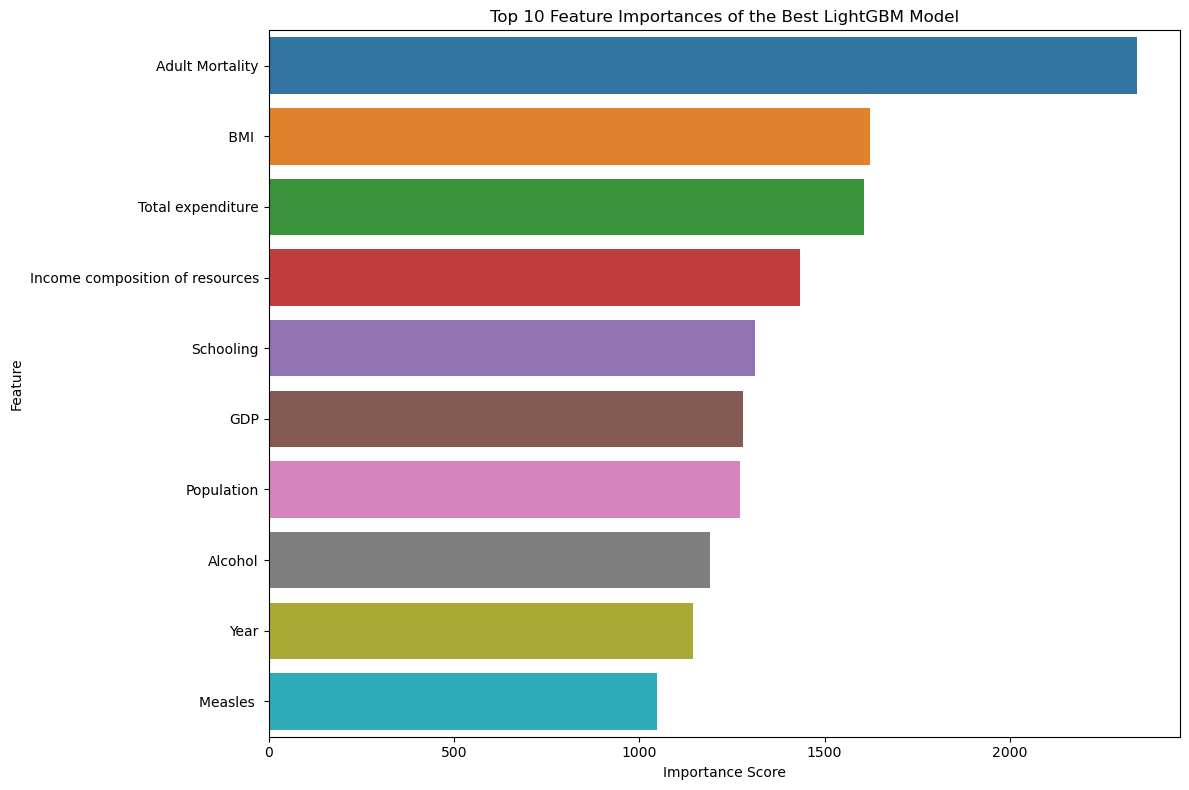

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

best_lgb_reg = lgb.LGBMRegressor(**best_params, random_state=42)
best_lgb_reg.fit(X_train, y_train)
best_lgb_reg_pred = best_lgb_reg.predict(X_test)

feature_importances = pd.Series(best_lgb_reg.feature_importances_, index=X.columns)

top_features = feature_importances.nlargest(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 10 Feature Importances of the Best LightGBM Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [21]:
import subprocess
installed_packages = subprocess.check_output(['pip', 'freeze']).decode('utf-8')
with open('requirements.txt', 'w') as f:
    f.write(installed_packages)

print("requirements.txt file created.")

requirements.txt file created.
